## Inference Code for 'Neural Nano-Optics for High-quality Thin Lens Imaging'

#### This notebook can be used to produce the experimental reconstructions shown in the manuscript and in the supplemental information.

In [1]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)


import tensorflow_addons as tfa
import numpy as np
from networks.select import select_G
from args import parse_args
import metasurface.solver as solver
import metasurface.conv as conv
import matplotlib.pyplot as plt
import sys

In [2]:
# Set up the arguments for real inference
sys.argv=['','--train_dir','.',\
             '--test_dir' ,'.',\
             '--save_dir' ,'.',\
             '--ckpt_dir' ,'experimental/ckpt/',\
             '--real_psf' ,'./experimental/data/psf/psf.npy',\
             '--psf_mode' ,'REAL_PSF',\
             '--conv_mode','REAL',\
             '--conv'     ,'full_size']
args = parse_args()

Namespace(G_beta1=0.9, G_iters=1, G_lr=0.0001, G_network='FP', Norm_loss_weight=1.0, P_loss_weight=0.0, Phase_beta1=0.9, Phase_iters=1, Phase_lr=0.005, Spatial_loss_weight=0.0, a_poisson=4e-05, alpha=270.176968209, aug_rotate=False, b_sqrt=1e-05, batch_weights=[1.0], bound_val=1000.0, ckpt_dir='experimental/ckpt/', conv='full_size', conv_mode='REAL', do_taper=True, log_freq=500, loss_mode='L1', mag=8.1, max_to_keep=2, metasurface='zeros', normalize_psf=False, num_coeffs=8, offset=True, psf_mode='REAL_PSF', real_psf='./experimental/data/psf/psf.npy', s1=0.0009, s2=0.0014, save_dir='.', save_freq=1000, snr_init=4.0, snr_opt=False, steps=1000000000, target_wavelength=5.11e-07, test_dir='.', theta_base=[0.0, 5.0, 10.0, 15.0], train_dir='.', use_general_phase=False, vgg_layers='block2_conv2,block3_conv2')


In [15]:
with tf.device('/CPU:0'):
    # Initialize and restore deconvolution method
    params = solver.initialize_params(args)
    params['conv_fn'] = conv.convolution_tf(params, args)
    params['deconv_fn'] = conv.deconvolution_tf(params, args)

    snr = tf.Variable(args.snr_init, dtype=tf.float32)
    G = select_G(params, args)
    checkpoint = tf.train.Checkpoint(G=G, snr=snr)

    status = checkpoint.restore(tf.train.latest_checkpoint(args.ckpt_dir, latest_filename=None))
    status.expect_partial()

def phase_func(x,a2,a4,a6,a8,a10,a12,a14,a16): return a2*x**2 + a4*x**4 + a6*x**6 + a8*x**8 + a10*x**10 + a12*x**12 + a14*x**14 + a16*x**16
360
Image width: 720
PSF width: 360
Load width: 1440
Network width: 1080
Out width: 720

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x0000023746A89688> and <keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000023746D4C448>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x0000023746ECE688> and <keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000023746E1F088>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x0000023746E76048> and <keras.layers.core.tf_op_layer.TFOpLambda object at 0x0000023746E30748>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x0000023746EE7688> and <keras.layers.core.tf_op_layer.TFOpLam

# Perform deconvolution

In [16]:
# Check that the dimensions agree with experimental captures
assert(params['image_width'] == 720)
assert(params['psf_width'] == 360)
assert(params['network_width'] == 1080)

In [17]:
# Load in experimentally measured PSFs
psf = (np.load('./experimental/data/psf/psf.npy'))
psf = tf.constant(psf)
psf = tf.image.resize_with_crop_or_pad(psf, params['psf_width'], params['psf_width'])
psf = psf / tf.reduce_sum(psf, axis=(1,2), keepdims=True)

In [18]:
def reconstruct(img_name, psf, snr, G):
    img = np.load(img_name)
    _, G_img, _ = params['deconv_fn'](img, psf, snr, G, training=False)
    G_img_ = G_img.numpy()[0,:,:,:]

    # Vignette Correct
    vig_factor = np.load('experimental/data/vignette_factor.npy')[0,:,:,:]
    G_img_ = G_img_ * vig_factor
    
    # Gain
    G_img_ = G_img_ * 1.2
    G_img_[G_img_ > 1.0] = 1.0

    # Contrast Normalization
    minval = np.percentile(G_img_, 5)
    maxval = np.percentile(G_img_, 95)
    G_img_ = np.clip(G_img_, minval, maxval)
    G_img_ = (G_img_ - minval) / (maxval - minval)
    G_img_[G_img_ > 1.0] = 1.0

    plt.figure(figsize=(6,6))
    plt.imshow(G_img_)

### Reconstruct Images

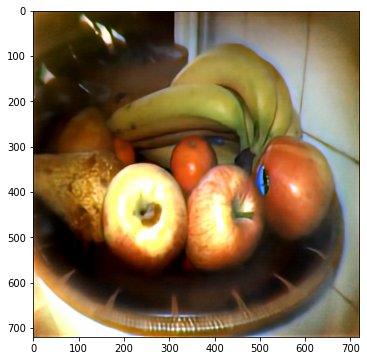

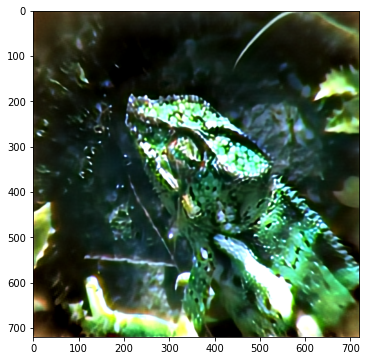

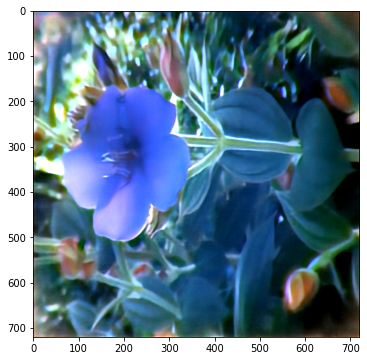

In [19]:
# Figure 3
reconstruct('./experimental/data/captures/138301.npy', psf, snr, G)
reconstruct('./experimental/data/captures/102302.npy', psf, snr, G)
reconstruct('./experimental/data/captures/110802.npy', psf, snr, G)

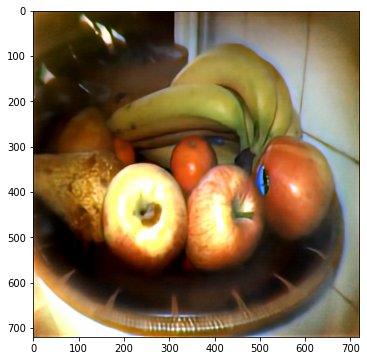

In [12]:
reconstruct('./experimental/data/captures/138301.npy', psf, snr, G)